In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

In [10]:
env_name = 'Taxi-v2'
#env_name = 'Breakout-ram-v0'

In [11]:
environment = env.Environment(
    environment=gym.make(env_name), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=500,
    representation_method='one_hot_encoding'
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [12]:
#model = linears.Linear(
#    input_dimension=environment.get_input_dimension(), 
#    n_actions=environment.n_actions,
#    bias=False
#)

model = mlps.MLP(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=100,
    n_hidden_layers=2,
    n_actions=environment.n_actions,
    dropout=.5
)

optimiser = torch.optim.Adam(model.parameters(), lr=.001)
#optimiser = torch.optim.SGD(model.parameters(), lr=1., momentum=0)

agent = agents.DQNAgent(
    model,
    optimiser, 
    gamma=.99, 
    temperature=10, 
    algorithm='sarsa', 
    n_actions=environment.n_actions,
    use_double_learning=True,
    terminal_state=environment.max_obs
)

environment.agent = agent

In [20]:
print(environment.agent.q(environment.state_representation(479)))
model.load_state_dict(torch.load('../saved/taxi/mlp/state_dict.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(479)))

[ 0.00255752  0.0615861  -0.03100201 -0.03873217  0.00391197  0.06503153]
[-60.705627 -60.369904 -60.683525 -59.44931  -67.97068  -69.03528 ]


# Experiment

## Training

100%|###############################################################| 10/10 [02:28<00:00, 15.50s/it]


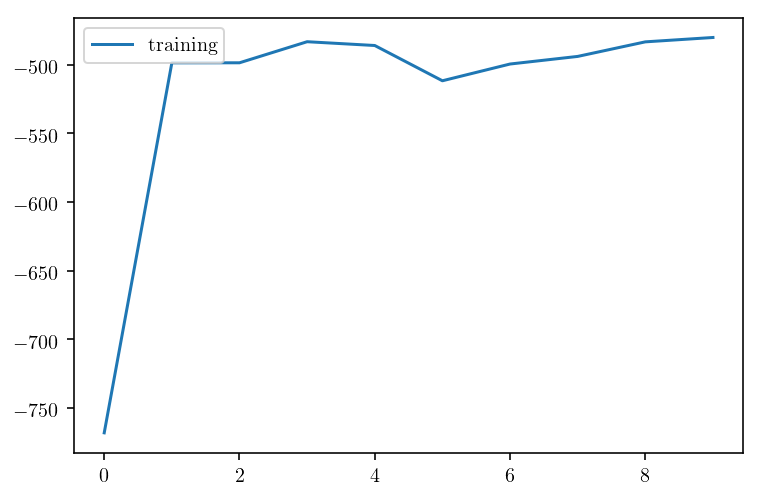

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

[-15.012737 -15.203692 -15.097611 -15.485725 -22.201166 -22.617798]
[-17.11503  -17.349186 -17.213772 -17.657484 -25.375593 -25.813595]
[-15.461468 -15.661091 -15.547777 -15.946436 -22.876825 -23.297455]


100%|###############################################################| 10/10 [02:28<00:00, 14.22s/it]


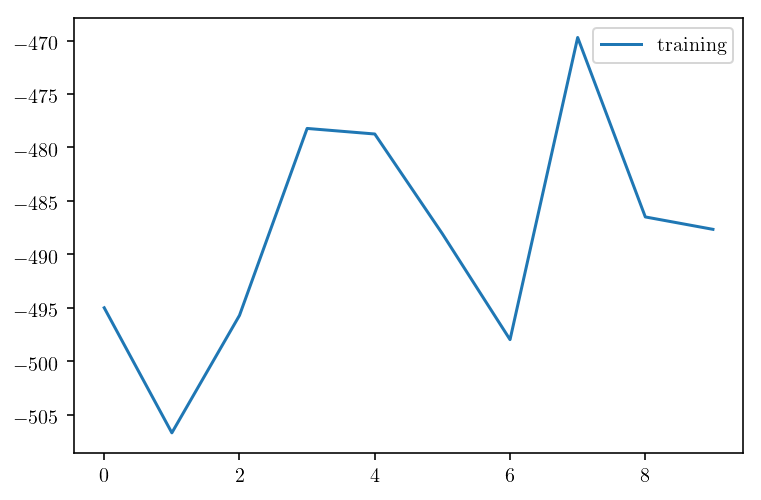

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

[-34.400944 -33.85272  -34.24382  -33.99862  -41.32415  -42.024536]
[-36.255997 -35.681267 -36.088432 -35.833553 -43.59085  -44.306686]
[-24.340696 -23.935625 -24.236307 -24.053415 -29.064753 -29.659533]


 30%|###################2                                            | 3/10 [00:39<01:33, 13.33s/it]

In [ ]:
agent.commit()
returns_train = []
returns_eval = []
q_estimation = []

for _ in range(40):
    
    returns = environment.train(segments=10, episodes=100)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    #plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .96
    
    returns_train.append(np.mean(returns.T[0]))
    returns_eval.append(np.mean(returns.T[1]))
 
    q_estimation.append(environment.agent.q(environment.state_representation(479)))
    print(environment.agent.q(environment.state_representation(1)))
    print(environment.agent.q(environment.state_representation(200)))
    print(environment.agent.q(environment.state_representation(479)))
    
    environment.agent.save('../saved/taxi/mlp')

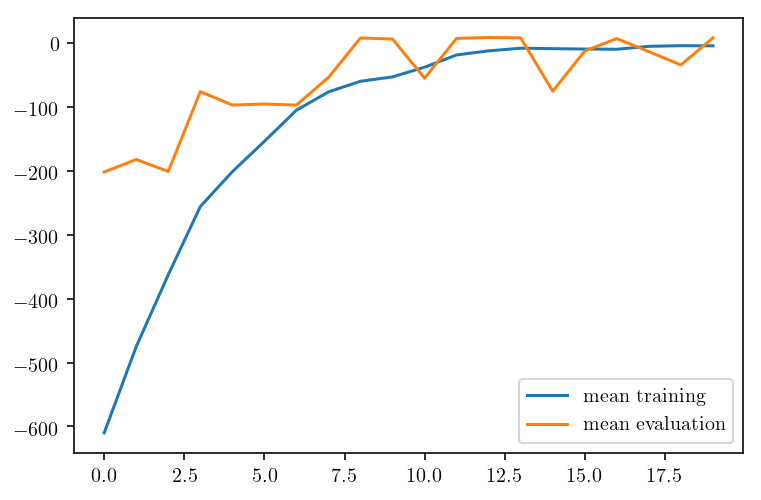

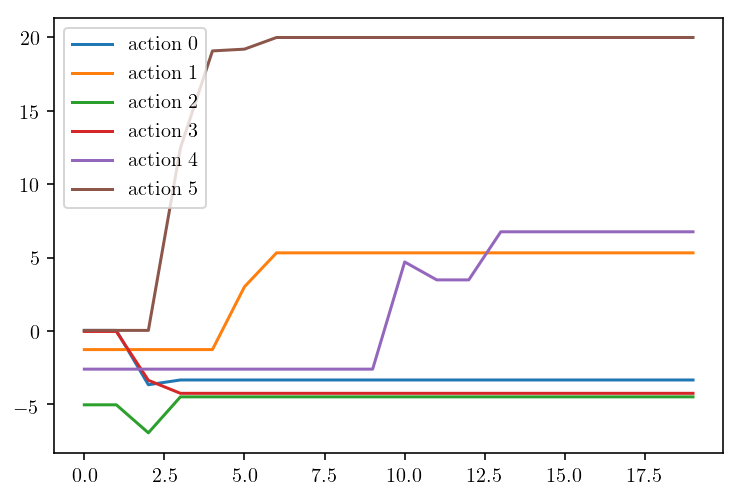

In [14]:
plt.figure()
plt.plot(returns_train, label='mean training')
plt.plot(returns_eval, label='mean evaluation')
plt.legend()
plt.show()

q_estimation = np.asarray(q_estimation)
plt.figure()
for i in range(environment.n_actions):
    plt.plot(q_estimation[:, i], label='action ' + str(i))
plt.legend()
plt.show()

## Testing

In [17]:
for _ in range(1):
    environment.exploration_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
269
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
269
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
169
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
149
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
169
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
189
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
89
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
69
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
49
+---------+
|R: | : :G|
| : : : : |
| :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
369
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
369
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
489
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
469
+---------+
|R: | :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
429
+---------+
|R: | : :G|

In [15]:
for _ in range(1):
    environment.evaluation_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 444
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 344
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 244
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 264
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 164
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 184
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 84
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 96
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 76
+---------+
|R: |_: :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:

## Save

In [41]:
environment.agent.save('../saved/mixed_mlp')

In [28]:
environment.agent.terminal_state

0

In [39]:
s = np.zeros(501)
s[479]=1
environment.agent.q(s)

array([-7.6510696, -7.0044036, -8.631231 , -8.776291 , -7.7975073,
       -1.8874221], dtype=float32)